In [56]:
# Import packages
import os
import datetime
from datetime import date

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    ConfusionMatrixDisplay
)

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import CategoricalDtype

%matplotlib inline
sns.set()  # Setting seaborn as default style even if use only matplotlib

# constants
audio_features_col_names = [
    "Danceability",
    "Energy",
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Valence",
]

# reading data
spotify_filepath = os.path.join(os.getcwd(), "spotify", "spotify.csv")
print(spotify_filepath)

# creating dataframe
spotify_data = pd.read_csv(spotify_filepath, delimiter=";")

spotify_data.drop(["Song URL"], axis=1, inplace=True, errors="ignore")  # drop url
# spotify_data.info()

# make "Date" column datetime type
spotify_data["Date"] = pd.to_datetime(spotify_data["Date"], dayfirst=True)
spotify_data.loc[0]["Date"]

# reverse dates
spotify_data = spotify_data.sort_values(by="Date")
# spotify_data.head()
# ranks are also reversed now...

# Scale the audio features.
spotify_data["Loudness"] = spotify_data["Loudness"].apply(lambda x: np.log10(np.abs(x)) / 60)
spotify_data

/home/jovyan/spotify/spotify.csv


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id
651935,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,0.063118,0.248,0.076,0.00,0.684,Artist 2,Kanye West,Nationality 2,United States,Anglo-America,1,1.000000,2KpCpk6HjXXLb7nnXoXA5O
651770,62,Sexual,"NEIKED, Dyo",2017-01-01,0.803,0.569,0.064479,0.074,0.062,0.00,0.809,Artist 1,NEIKED,Nationality 1,Sweden,Europe,139,70.000000,3AsAuGTaDQzavZZThyYlop
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,0.066372,0.370,0.157,0.00,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.000000,5hYTyyh2odQKphUbMqc5gN
651768,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.00,0.392,Artist 2,Rihanna,Nationality 2,Barbados,Anglo-America,141,70.000000,11KJSRSgaDxqydKYiD2Jew
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.00,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.000000,11KJSRSgaDxqydKYiD2Jew
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,135,Can't Hold Us (feat. Ray Dalton),"Macklemore & Ryan Lewis, Macklemore, Ryan Lewi...",2023-05-29,0.633,0.927,0.060835,0.084,0.027,0.00,0.880,Artist 4,Ray Dalton,Nationality 4,United States,Anglo-America,66,16.500000,22skzmqfdWrjJylampe0kt
199,136,Cartão Black,"MC Caverinha, KayBlack, Wall Hein",2023-05-29,0.842,0.468,0.065551,0.637,0.255,0.00,0.547,Artist 1,MC Caverinha,Nationality 1,Brazil,Latin-America,65,21.666667,12YCtLHGk6tP6RbHDHflCs
200,136,Cartão Black,"MC Caverinha, KayBlack, Wall Hein",2023-05-29,0.842,0.468,0.065551,0.637,0.255,0.00,0.547,Artist 2,KayBlack,Nationality 2,Brazil,Latin-America,65,21.666667,12YCtLHGk6tP6RbHDHflCs
202,137,Apocalypse,Cigarettes After Sex,2023-05-29,0.369,0.467,0.065919,0.027,0.019,0.46,0.174,Artist 1,Cigarettes After Sex,Nationality 1,United States,Anglo-America,64,64.000000,3AVrVz5rK8Hrqo9YGiVGN5


In [2]:
# First make copy and drop irrelevant features
data_copy = spotify_data.copy(deep=True)
data_copy.drop(["Artists", '# of Artist', 'Artist (Ind.)', '# of Nationality', 'Continent',
                        'Points (Ind for each Artist/Nat)', 'Rank'], axis=1, inplace=True)

# group by song title and take average vlues for features but one value of points
data_by_song_mean = data_copy.groupby('Title').agg(
    {'Danceability': 'mean',
        'Energy': 'mean',
        'Loudness': 'mean',
        'Speechiness': 'mean',
        'Acousticness': 'mean',
        'Instrumentalness': 'mean',
        'Valence': 'mean',   # Average the feature columns
        'Points (Total)': 'sum'  },     # sum the first popularity values
)

data_by_song_mean


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points (Total)
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,287
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,194
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,24
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,1018
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,125
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,35
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,117
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,1161


In [3]:
# create new dataframe with just data from 2022
#data_copy_2022 = spotify_data.copy(deep=True)
#data_copy_2022.sort_values("Date", ascending=True)
#data_copy_2022 = data_copy_2022.loc[(data_copy_2022["Date"] > pd.to_datetime('2021-12-31')) # delete all dates excluding 2022
#& (data_copy_2022["Date"] < pd.to_datetime('2023-1-1'))]

# dataset with one song per row and averaged feature values
#songs_2022 = data_copy_2022.groupby("Title").mean(numeric_only=True)
#songs_2022.drop(['Points (Total)', 'Rank', 'Points (Ind for each Artist/Nat)'], axis=1, inplace=True)
#songs_2022

# dataset with one song per day per row and total points
points_per_day = spotify_data.drop(audio_features_col_names + ['Artists', '# of Artist', 'Artist (Ind.)', 'Nationality', '# of Nationality', 'Continent', 'Points (Ind for each Artist/Nat)', 'id', 'Rank'], axis=1)

# split dataframe by date
points_by_date = {date: data for date, data in points_per_day.groupby('Date')}
# Now, points_by_date is a dictionary where the keys are dates and the values are the DataFrames for each date.
# Modify each date DataFrame to ensure no duplicate songs and random points for each song
for date, data in points_by_date.items():
    # Group by Song Title and select one random row for each song
    points_by_date[date] = data.groupby('Title', as_index=False).sample(n=1)
    
    # Reset the index of each grouped DataFrame
    points_by_date[date].reset_index(drop=True, inplace=True)
# To access the DataFrame for a specific date (for example, "2022-01-01"):
points_1 = points_by_date[pd.to_datetime('2022-01-01')]

# Now, we want to create a new DataFrame where:
# - Each row corresponds to a Song Title,
# - Each column corresponds to a Date,
# - Each entry represents the "Points" for that song on that date.

# We first concatenate all the DataFrames by date into a single DataFrame
points_concatenated = pd.concat(points_by_date.values(), ignore_index=True)

# Now we pivot the DataFrame to the required format
points_per_date_and_title = points_concatenated.pivot(index='Title', columns='Date', values='Points (Total)')
# convert NaN values to 0
points_per_date_and_title = points_per_date_and_title.fillna(0)
# add a total points accumulated column
#points_per_date_and_title['Total Points'] = points_per_date_and_title.sum(axis=1)

# convert all entries to integers
points_per_date_and_title = points_per_date_and_title.astype(int)

points_per_date_and_title

Date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2023-05-20,2023-05-21,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29
Title,,,,,,,,,,,,,,,,,,,,,
'98 Braves,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#PROUDCATOWNERREMIX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$$$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$€ Freestyle,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ÎŸ. OG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
İmdat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Value Counts in the Dataframe (excluding NaN):
Value 0: 16952133 times
Value 1: 2340 times
Value 2: 2339 times
Value 3: 2341 times
Value 4: 2339 times
Value 5: 2347 times
Value 6: 2345 times
Value 7: 2339 times
Value 8: 2340 times
Value 9: 2340 times
Value 10: 2347 times
Value 11: 2346 times
Value 12: 2344 times
Value 13: 2345 times
Value 14: 2344 times
Value 15: 2343 times
Value 16: 2334 times
Value 17: 2353 times
Value 18: 2344 times
Value 19: 2344 times
Value 20: 2340 times
Value 21: 2352 times
Value 22: 2355 times
Value 23: 2342 times
Value 24: 2354 times
Value 25: 2348 times
Value 26: 2349 times
Value 27: 2343 times
Value 28: 2353 times
Value 29: 2345 times
Value 30: 2355 times
Value 31: 2345 times
Value 32: 2352 times
Value 33: 2346 times
Value 34: 2358 times
Value 35: 2357 times
Value 36: 2349 times
Value 37: 2345 times
Value 38: 2348 times
Value 39: 2359 times
Value 40: 2347 times
Value 41: 2346 times
Value 42: 2352 times
Value 43: 2355 times
Value 44: 2343 times
Value 45: 2348

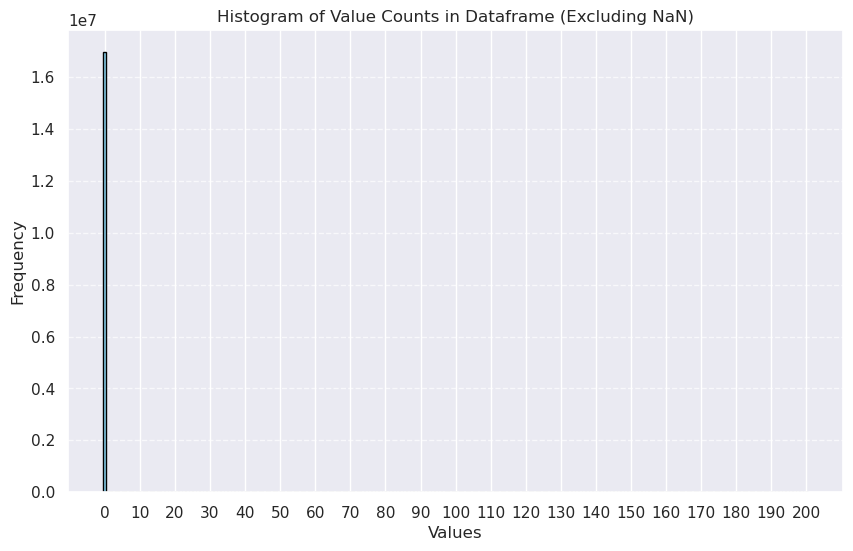

In [4]:

# Flatten the dataframe into a 1D array, ignoring NaN values
all_values = points_per_date_and_title.values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values

# Convert values to integers (since NaN removal results in float array)
all_values = all_values.astype(int)

# Count the occurrences of each value
value_counts = np.bincount(all_values, minlength=201)  # From 1 to 200

# Print the counts for each value
print("Value Counts in the Dataframe (excluding NaN):")
for value, count in enumerate(value_counts):
    if count > 0:  # Only print values that occur at least once
        print(f"Value {value}: {count} times")

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(201), value_counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Value Counts in Dataframe (Excluding NaN)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(range(0, 201, 10))  # Adjust x-axis ticks for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
import pandas as pd

# Assuming `points_per_date_and_title` is the original dataframe
# Step 1: Extract column names (excluding the first column which is song titles)
dates = points_per_date_and_title.columns[1:]  # Exclude the first column (song titles)

# Step 2: Categorize dates into weekdays and weekends
weekdays = []
weekends = []

for date in dates:
    # Ensure the date is a pandas Timestamp
    if isinstance(date, str):
        date = pd.Timestamp(date)
    day_of_week = date.weekday()  # Get the weekday (0=Monday, 6=Sunday)
    if day_of_week < 5:  # Monday-Friday
        weekdays.append(date)
    else:  # Saturday-Sunday
        weekends.append(date)

# Step 3: Compute averages for weekdays and weekends
weekday_avg = points_per_date_and_title[weekdays].mean(axis=1)  # Average across weekday columns
weekend_avg = points_per_date_and_title[weekends].mean(axis=1)  # Average across weekend columns

# Step 4: Create the new dataframe with the computed values
weekday_weekend = pd.DataFrame({  # Retain song titles (first column)
    "Weekday": weekday_avg,
    "Weekend": weekend_avg
})

# Display the new dataframe

weekday_weekend


# now create a dataframe where the rows are songs and columns are weekday and weekend

# Convert columns to datetime (if not already)
#points_per_date_and_title.columns = pd.to_datetime(points_per_date_and_title.columns)

# Create two masks: one for weekdays (Monday to Friday), and one for weekends (Saturday and Sunday)
#weekdays_mask = points_per_date_and_title.columns.weekday < 4  # Monday (0) to Thursday (3)
#weekends_mask = ~weekdays_mask  # Friday (4), Saturday (5), and Sunday (6)

# Calculate average points for weekdays (Monday to Friday)
#weekday_avg = points_per_date_and_title.loc[:, weekdays_mask].mean(axis=1, numeric_only=True)

# Calculate average points for weekends (Saturday and Sunday)
#weekend_avg = points_per_date_and_title.loc[:, weekends_mask].mean(axis=1, numeric_only=True)

# Create a new DataFrame with song titles as rows and "weekday" and "weekend" columns
#weekday_weekend = pd.DataFrame({
#    'Title': points_per_date_and_title.index,
#    'Weekday': weekday_avg,
#    'Weekend': weekend_avg
#})
#weekday_weekend

,Weekday,Weekend
Title,,
'98 Braves,0.103179,0.172156
!,0.086983,0.073353
#PROUDCATOWNERREMIX,0.007199,0.000000
$$$,0.470306,0.350299
$€ Freestyle,0.074985,0.000000
...,...,...
Î©. VIVRE UN PEU,0.020996,0.000000
ÎŸ. OG,0.070186,0.000000
İmdat,0.489502,0.516467


In [6]:
weekday_weekend.describe()

,Weekday,Weekend
count,7457.000000,7457.000000
mean,2.693278,2.693181
std,6.806753,6.709469
min,0.000000,0.000000
25%,0.047391,0.000000
50%,0.243551,0.306886
75%,1.803239,1.892216
max,104.493101,105.609281


On average, songs are equally popular on weekdays and weekends with similar distributions. But std is noticeably higher than the mean. Try to modify the popularity so that the std decreases.

In [7]:
weekday_weekend['difference'] = weekday_weekend['Weekday'] - weekday_weekend['Weekend']

weekday_greater = weekday_weekend[weekday_weekend['difference'] > 0]  # Songs where weekday > weekend
weekend_greater = weekday_weekend[weekday_weekend['difference'] < 0]  # Songs where weekend > weekday

#weekday_greater.describe()
weekend_greater.describe()



,Weekday,Weekend,difference
count,3007.000000,3007.000000,3007.000000
mean,2.567402,2.857514,-0.290111
std,5.975322,6.191304,0.594275
min,0.000000,0.001497,-10.079319
25%,0.103179,0.214072,-0.244374
50%,0.355729,0.473054,-0.099847
75%,1.721956,2.257485,-0.044458
max,104.493101,105.609281,-0.000060


In [8]:
# Define the new 'weekday > weekend' column based on the conditions
#weekday_weekend['Weekday > Weekend'] = np.where(
#    (weekday_weekend['Weekday'] > weekday_weekend['Weekend']) & (abs(weekday_weekend['Weekday'] - weekday_weekend['Weekend']) > 0.459384), 1,
#    np.where(
#        (weekday_weekend['Weekend'] > weekday_weekend['Weekday']) & (abs(weekday_weekend['Weekend'] - weekday_weekend['Weekday']) > 0.204730), 0, 2
#    )
#)



In [9]:
# Define the new 'weekday > weekend' column based on the conditions
weekday_weekend['Weekday > Weekend'] = np.where(
    (weekday_weekend['Weekday'] > weekday_weekend['Weekend']) , 1, 0
)


In [10]:
# drop all 2's
weekday_weekend = weekday_weekend[weekday_weekend['Weekday > Weekend'] != 2].drop(['Weekend','Weekday','difference'],axis=1)
weekday_weekend

,Weekday > Weekend
Title,
'98 Braves,0
!,1
#PROUDCATOWNERREMIX,1
$$$,1
$€ Freestyle,1
...,...
Î©. VIVRE UN PEU,1
ÎŸ. OG,1
İmdat,0


In [11]:
data_by_song_mean

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points (Total)
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,287
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,194
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,24
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,1018
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,125
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,35
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,117
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,1161


In [12]:
# Merge the two DataFrames on the song title (index)
songs_features_weekday = data_by_song_mean.join(weekday_weekend, how='inner')
songs_features_weekday = songs_features_weekday.drop('Points (Total)', axis=1)
songs_features_weekday

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Weekday > Weekend
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,0
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,1
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,1
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,1
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,1
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,1
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,1
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,0


In [13]:
# Problem: some values of loudness (3) are negative
# Filter rows with any negative values
negative_rows = songs_features_weekday[(songs_features_weekday < 0).any(axis=1)]

# Print the filtered rows
print(negative_rows)

# Solution: set them to 0
songs_features_weekday[songs_features_weekday < 0] = 0

                                                    Danceability    Energy  \
Title                                                                        
Agora Vai Sentar                                        0.814000  0.653000   
Desde Esa Noche (feat. Maluma)                          0.780000  0.929000   
Girls                                                   0.570000  0.974000   
Go                                                      0.755000  0.898000   
Good Drank                                              0.836000  0.776000   
It's A Raid (feat. Post Malone)                         0.472000  0.996000   
Live It Up - Official Song 2018 FIFA World Cup ...      0.582000  0.944000   
Murder In My Mind                                       0.712000  0.972000   
PUNTO 40                                                0.861459  0.828164   
Puta Mexica                                             0.853000  0.913000   
Sal y Perrea                                            0.786000

Visualisation

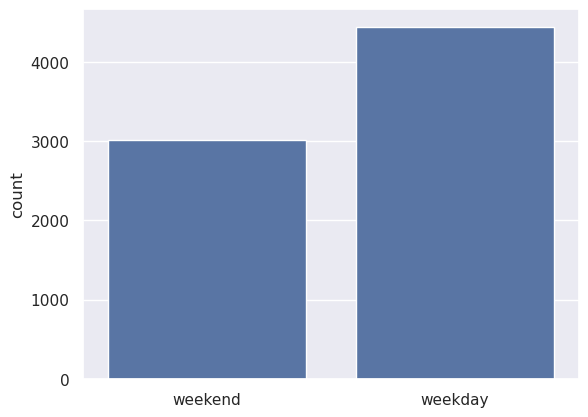

In [14]:
# number of songs more populat on weekdays vs weekends
ax = sns.countplot(x='Weekday > Weekend', data=songs_features_weekday)
ax.set_xticks([0, 1]) # what does this do exactly?
ax.set_xticklabels(['weekend', 'weekday'])
plt.xlabel('') # removes "is-span" label from x axis
plt.show()

Imbalance! We balance out the data by oversampling.

In [15]:
# now try Naive Bayes on this dataset
#X = songs_features_weekday.drop('Weekday > Weekend', axis=1)
#y = songs_features_weekday['Weekday > Weekend']

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

# 'string {}'.format(x) prints the string + x in the {} position
#print('Number of songs more popular on weekdays: {}'.format((y==1).sum())) #summing all entries of y which is equal to 1
#print('Number of songs more popular on weekends: {}'.format((y==0).sum()))


In [16]:
!pip install imbalanced-learn

In [17]:
# Oversampling due to class imbalance
from imblearn.over_sampling import SMOTE
from collections import Counter

# Example DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv('your_file.csv')  # Load your dataset here

# Separate features (X) and target (y)
X = songs_features_weekday.iloc[:, :-1]  # All columns except the last one
y = songs_features_weekday.iloc[:, -1]   # Binary classification column

# Check the class distribution
print("Original class distribution:", Counter(y))

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("Resampled class distribution:", Counter(y_resampled))

# Combine the resampled data into a new DataFrame
balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=[songs_features_weekday.columns[-1]])], axis=1)

# Save or use the balanced DataFrame
# balanced_df.to_csv('balanced_dataset.csv', index=False)  # Save if needed
print("Balanced dataset created successfully.")

Original class distribution: Counter({1: 4442, 0: 3015})
Resampled class distribution: Counter({0: 4442, 1: 4442})
Balanced dataset created successfully.


NAIVE BAYES

In [40]:
# now try Naive Bayes on this dataset
X_balanced = balanced_df.drop('Weekday > Weekend', axis=1)
y_balanced = balanced_df['Weekday > Weekend']

# 'string {}'.format(x) prints the string + x in the {} position
print('Number of songs more popular on weekdays: {}'.format((y_balanced==1).sum())) #summing all entries of y which is equal to 1
print('Number of songs more popular on weekends: {}'.format((y_balanced==0).sum()))

Number of songs more popular on weekdays: 4442
Number of songs more popular on weekends: 4442


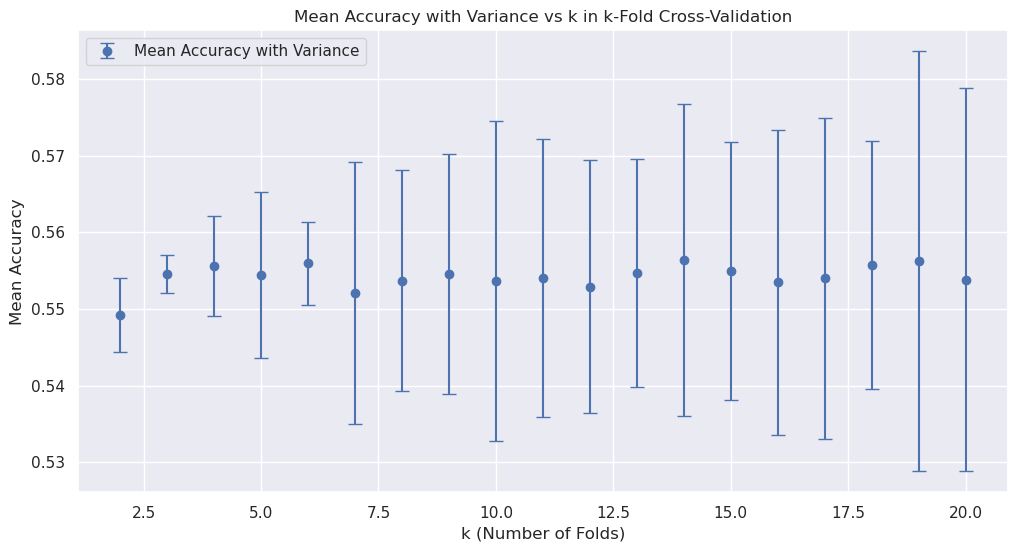

Results for k-Fold Cross-Validation:
     k  Mean Accuracy  Variance
0    2       0.549190  0.000023
1    3       0.554592  0.000006
2    4       0.555606  0.000043
3    5       0.554480  0.000117
4    6       0.555944  0.000029
5    7       0.552116  0.000293
6    8       0.553692  0.000207
7    9       0.554594  0.000246
8   10       0.553692  0.000437
9   11       0.554029  0.000331
10  12       0.552905  0.000273
11  13       0.554704  0.000222
12  14       0.556390  0.000413
13  15       0.554929  0.000284
14  16       0.553467  0.000397
15  17       0.554026  0.000440
16  18       0.555715  0.000264
17  19       0.556277  0.000750
18  20       0.553801  0.000625

Best k: 6.0
Best Mean Accuracy: 0.5559
Best Variance: 0.0000

Final Naive Bayes Classifier Metrics:
Accuracy: 0.5559
Variance: 0.0000
Mean Squared Error: 0.4441


In [19]:
# Assuming the balanced dataset is already created as `balanced_df`
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Range of k values for k-fold cross-validation
k_values = range(2, 21)  # Test k from 2 to 20
results = []

# Perform k-fold validation for each k
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train Naive Bayes Classifier
        model = GaussianNB()
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record mean accuracy and variance for this k
    mean_accuracy = np.mean(accuracies)
    variance = np.var(accuracies)
    results.append((k, mean_accuracy, variance))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['k', 'Mean Accuracy', 'Variance'])

# Select the best k based on the lowest variance and highest accuracy
best_k_row = results_df.loc[4] # chosen from graph by inspection then added retrospectively
best_k = best_k_row['k']
best_mean_accuracy = best_k_row['Mean Accuracy']
best_variance = best_k_row['Variance']

# Plot mean accuracy with variance as error bars
plt.figure(figsize=(12, 6))

plt.errorbar(
    results_df['k'], 
    results_df['Mean Accuracy'], 
    yerr=np.sqrt(results_df['Variance']),  # Standard deviation as error bars
    fmt='o', 
    label='Mean Accuracy with Variance',
    capsize=5
)

plt.title('Mean Accuracy with Variance vs k in k-Fold Cross-Validation')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train a final Naive Bayes model with the best k
kf = KFold(n_splits=int(best_k), shuffle=True, random_state=42)
final_accuracies = []
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = GaussianNB()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    final_accuracies.append(accuracy_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Calculate final metrics
final_mean_accuracy = np.mean(final_accuracies)
final_variance = np.var(final_accuracies)
final_mse = np.mean(mse_scores)

# Display results
print("Results for k-Fold Cross-Validation:")
print(results_df)

print(f"\nBest k: {best_k}")
print(f"Best Mean Accuracy: {best_mean_accuracy:.4f}")
print(f"Best Variance: {best_variance:.4f}")

print("\nFinal Naive Bayes Classifier Metrics:")
print(f"Accuracy: {final_mean_accuracy:.4f}")
print(f"Variance: {final_variance:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

k=6 is a reasonable choice , since mean doesn't vary much, but variance is noticeably low

LOGISTIC REGRESSION

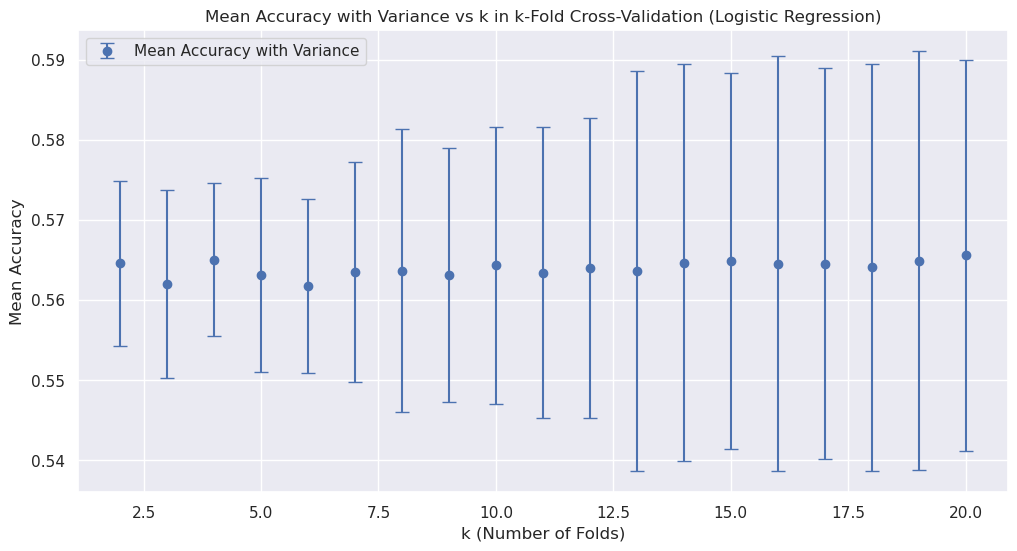

Results for k-Fold Cross-Validation:
     k  Mean Accuracy  Variance
0    2       0.564611  0.000107
1    3       0.562020  0.000137
2    4       0.565061  0.000091
3    5       0.563147  0.000146
4    6       0.561794  0.000117
5    7       0.563598  0.000189
6    8       0.563706  0.000312
7    9       0.563148  0.000253
8   10       0.564381  0.000299
9   11       0.563479  0.000329
10  12       0.564044  0.000352
11  13       0.563704  0.000623
12  14       0.564715  0.000617
13  15       0.564947  0.000552
14  16       0.564606  0.000673
15  17       0.564601  0.000595
16  18       0.564149  0.000646
17  19       0.564936  0.000686
18  20       0.565618  0.000598

Best k: 5.0
Best Mean Accuracy: 0.5631
Best Variance: 0.0001

Final Logistic Regression Classifier Metrics:
Accuracy: 0.5631
Variance: 0.0001
Mean Squared Error: 0.4369


In [20]:
# Assuming the balanced dataset is already created as `balanced_df`
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Range of k values for k-fold cross-validation
k_values = range(2, 21)  # Test k from 2 to 20
results = []

# Perform k-fold validation for each k
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train Logistic Regression Model
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record mean accuracy and variance for this k
    mean_accuracy = np.mean(accuracies)
    variance = np.var(accuracies)
    results.append((k, mean_accuracy, variance))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['k', 'Mean Accuracy', 'Variance'])

# Select the best k based on the lowest variance and highest accuracy
best_k_row = results_df.loc[3] # chosen from graph by inspection then added retrospectively
best_k = best_k_row['k']
best_mean_accuracy = best_k_row['Mean Accuracy']
best_variance = best_k_row['Variance']

# Plot mean accuracy with variance as error bars
plt.figure(figsize=(12, 6))

plt.errorbar(
    results_df['k'], 
    results_df['Mean Accuracy'], 
    yerr=np.sqrt(results_df['Variance']),  # Standard deviation as error bars
    fmt='o', 
    label='Mean Accuracy with Variance',
    capsize=5
)

plt.title('Mean Accuracy with Variance vs k in k-Fold Cross-Validation (Logistic Regression)')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train a final Logistic Regression model with the best k
kf = KFold(n_splits=int(best_k), shuffle=True, random_state=42)
final_accuracies = []
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    final_accuracies.append(accuracy_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Calculate final metrics
final_mean_accuracy = np.mean(final_accuracies)
final_variance = np.var(final_accuracies)
final_mse = np.mean(mse_scores)

# Display results
print("Results for k-Fold Cross-Validation:")
print(results_df)

print(f"\nBest k: {best_k}")
print(f"Best Mean Accuracy: {best_mean_accuracy:.4f}")
print(f"Best Variance: {best_variance:.4f}")

print("\nFinal Logistic Regression Classifier Metrics:")
print(f"Accuracy: {final_mean_accuracy:.4f}")
print(f"Variance: {final_variance:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

A reasonable choice here is 5

In [21]:
# Your Code goes here:
weight = model.coef_
bias = model.intercept_
print('Weight of the Logistic Regression classifier: {}'.format(weight))
print('Bias of the Logistic Regression classifier: {}'.format(bias))

Weight of the Logistic Regression classifier: [[-0.77082792 -0.4185575   0.08419509 -0.14419077 -0.64133272  0.20571204
  -0.98441845]]
Bias of the Logistic Regression classifier: [1.43398851]


KNN

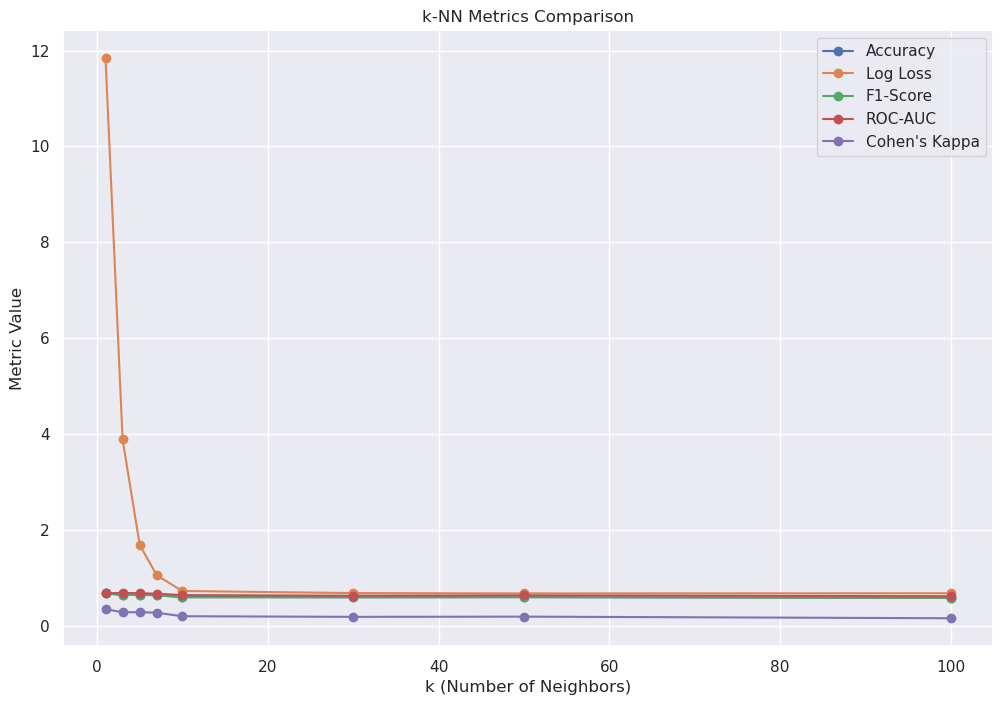

k-NN Metrics Comparison:
     k  Accuracy   Log Loss  F1-Score   ROC-AUC  Cohen's Kappa
0    1  0.671541  11.838860  0.669803  0.671460       0.342975
1    3  0.637795   3.882793  0.637369  0.681053       0.275535
2    5  0.640045   1.685245  0.639563  0.673598       0.280031
3    7  0.633296   1.046964  0.631701  0.664928       0.266483
4   10  0.597300   0.720595  0.587576  0.634692       0.194322
5   30  0.590551   0.677151  0.587810  0.622361       0.180952
6   50  0.592801   0.670111  0.591585  0.629145       0.185502
7  100  0.575928   0.673762  0.575632  0.610907       0.151806

Best k based on Accuracy: 1.0


In [54]:
# Split the balanced dataset into train and test sets
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Range of k values for k-Nearest Neighbors
k_values = [1, 3, 5, 7, 10, 30, 50, 100]
results = []

# Evaluate k-Nearest Neighbors for each k
for k in k_values:
    # Train k-NN Classifier
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted for imbalanced classes
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Append metrics to results
    results.append((k, accuracy, logloss, f1, roc_auc, kappa))

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['k', 'Accuracy', 'Log Loss', 'F1-Score', 'ROC-AUC', "Cohen's Kappa"])

# display the metrics for each k
plt.figure(figsize=(12, 8))
plt.plot(results_df['k'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['k'], results_df['Log Loss'], label='Log Loss', marker='o')
plt.plot(results_df['k'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.plot(results_df['k'], results_df['ROC-AUC'], label='ROC-AUC', marker='o')
plt.plot(results_df['k'], results_df["Cohen's Kappa"], label="Cohen's Kappa", marker='o')

plt.title('k-NN Metrics Comparison')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Display the metrics table (optional, for reference)
print("k-NN Metrics Comparison:")
print(results_df)

# Identify the best k based on Accuracy and F1-Score
best_k_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_k = best_k_row['k']

print(f"\nBest k based on Accuracy: {best_k}")

Reasonable to choose k=30

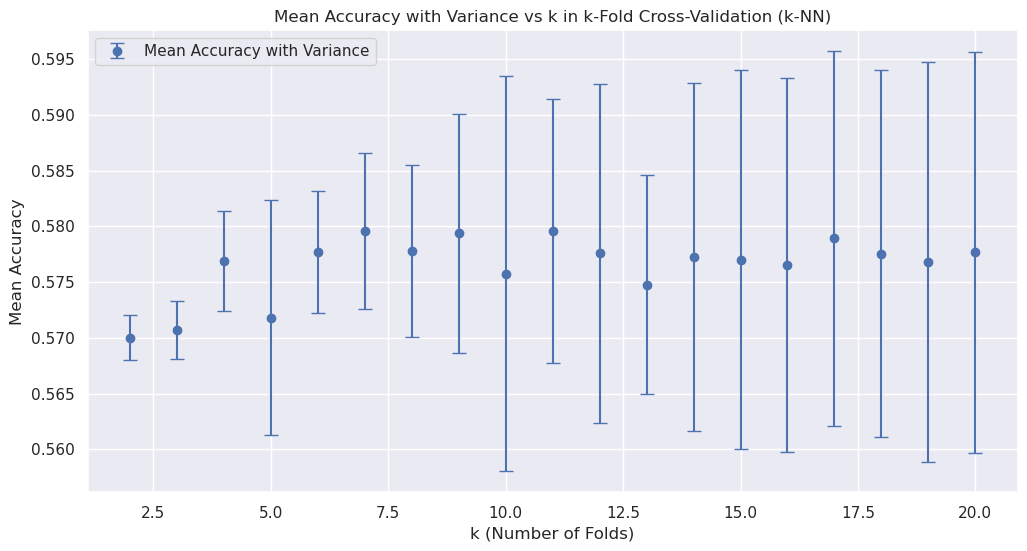

Results for k-Fold Cross-Validation:
     k  Mean Accuracy  Variance
0    2       0.570014  0.000004
1    3       0.570689  0.000007
2    4       0.576880  0.000020
3    5       0.571814  0.000111
4    6       0.577668  0.000030
5    7       0.579580  0.000049
6    8       0.577779  0.000059
7    9       0.579356  0.000115
8   10       0.575757  0.000314
9   11       0.579581  0.000139
10  12       0.577558  0.000231
11  13       0.574741  0.000096
12  14       0.577217  0.000244
13  15       0.576994  0.000289
14  16       0.576543  0.000281
15  17       0.578904  0.000282
16  18       0.577557  0.000271
17  19       0.576771  0.000322
18  20       0.577665  0.000323

Best k: 11.0
Best Mean Accuracy: 0.5796
Best Variance: 0.0001

Final k-NN Classifier Metrics:
Accuracy: 0.6072
Variance: 0.0004
Mean Squared Error: 0.3928


In [51]:
# Assuming the balanced dataset is already created as `balanced_df`
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Range of k values for k-fold cross-validation
k_values = range(2, 21)  # Test k from 2 to 20
results = []

# Perform k-fold validation for each k
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train k-Nearest Neighbors Classifier
        model = KNeighborsClassifier(n_neighbors=30)  # Default k=5 for k-NN
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record mean accuracy and variance for this k
    mean_accuracy = np.mean(accuracies)
    variance = np.var(accuracies)
    results.append((k, mean_accuracy, variance))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['k', 'Mean Accuracy', 'Variance'])

# Select the best k based on the lowest variance and highest accuracy
best_k_row = results_df.loc[9]
best_k = best_k_row['k']
best_mean_accuracy = best_k_row['Mean Accuracy']
best_variance = best_k_row['Variance']

# Plot mean accuracy with variance as error bars
plt.figure(figsize=(12, 6))

plt.errorbar(
    results_df['k'], 
    results_df['Mean Accuracy'], 
    yerr=np.sqrt(results_df['Variance']),  # Standard deviation as error bars
    fmt='o', 
    label='Mean Accuracy with Variance',
    capsize=5
)

plt.title('Mean Accuracy with Variance vs k in k-Fold Cross-Validation (k-NN)')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train a final k-NN model with the best k
kf = KFold(n_splits=int(best_k), shuffle=True, random_state=42)
final_accuracies = []
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = KNeighborsClassifier(n_neighbors=5)  # Default k=5 for k-NN
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    final_accuracies.append(accuracy_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Calculate final metrics
final_mean_accuracy = np.mean(final_accuracies)
final_variance = np.var(final_accuracies)
final_mse = np.mean(mse_scores)

# Display results
print("Results for k-Fold Cross-Validation:")
print(results_df)

print(f"\nBest k: {best_k}")
print(f"Best Mean Accuracy: {best_mean_accuracy:.4f}")
print(f"Best Variance: {best_variance:.4f}")

print("\nFinal k-NN Classifier Metrics:")
print(f"Accuracy: {final_mean_accuracy:.4f}")
print(f"Variance: {final_variance:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

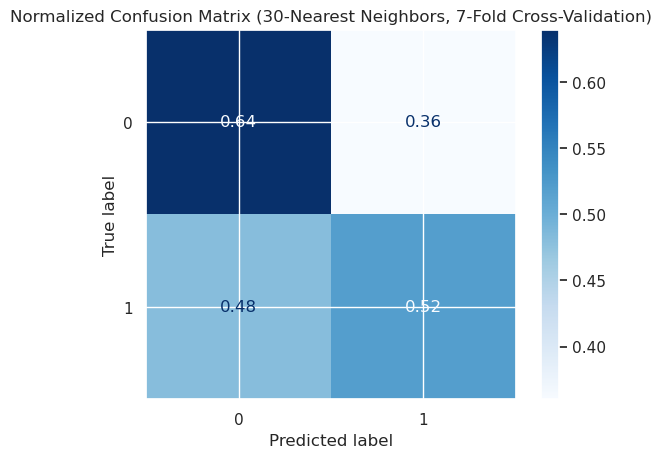

Metrics for 30-Nearest Neighbors Classifier (7-Fold Cross-Validation):
Accuracy: 0.5796
Log Loss: 0.6793
F1-Score: 0.5781
ROC-AUC: 0.6108
Cohen's Kappa: 0.1593
Mean Squared Error: 0.4204


In [57]:
# final classification using 30 nearest neighbours and 7-fold validation set
# Assuming balanced_df is the dataset
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Initialize 7-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Initialize metrics
accuracy_list = []
log_loss_list = []
f1_score_list = []
roc_auc_list = []
kappa_list = []
mse_list = []

# Initialize arrays to accumulate confusion matrix data
conf_matrix_sum = np.zeros((2, 2))  # Assuming binary classification

# Perform 7-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a k-NN Classifier with 30 neighbors
    model = KNeighborsClassifier(n_neighbors=30)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Accumulate metrics
    accuracy_list.append(accuracy)
    log_loss_list.append(logloss)
    f1_score_list.append(f1)
    roc_auc_list.append(roc_auc)
    kappa_list.append(kappa)
    mse_list.append(mse)
    
    # Accumulate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    conf_matrix_sum += conf_matrix

# Average metrics across folds
final_accuracy = np.mean(accuracy_list)
final_log_loss = np.mean(log_loss_list)
final_f1_score = np.mean(f1_score_list)
final_roc_auc = np.mean(roc_auc_list)
final_kappa = np.mean(kappa_list)
final_mse = np.mean(mse_list)

# Normalize confusion matrix sum for display
final_conf_matrix = conf_matrix_sum / kf.n_splits

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (30-Nearest Neighbors, 7-Fold Cross-Validation)')
plt.show()

# Print metrics
print("Metrics for 30-Nearest Neighbors Classifier (7-Fold Cross-Validation):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Log Loss: {final_log_loss:.4f}")
print(f"F1-Score: {final_f1_score:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"Cohen's Kappa: {final_kappa:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

DECISION TREES






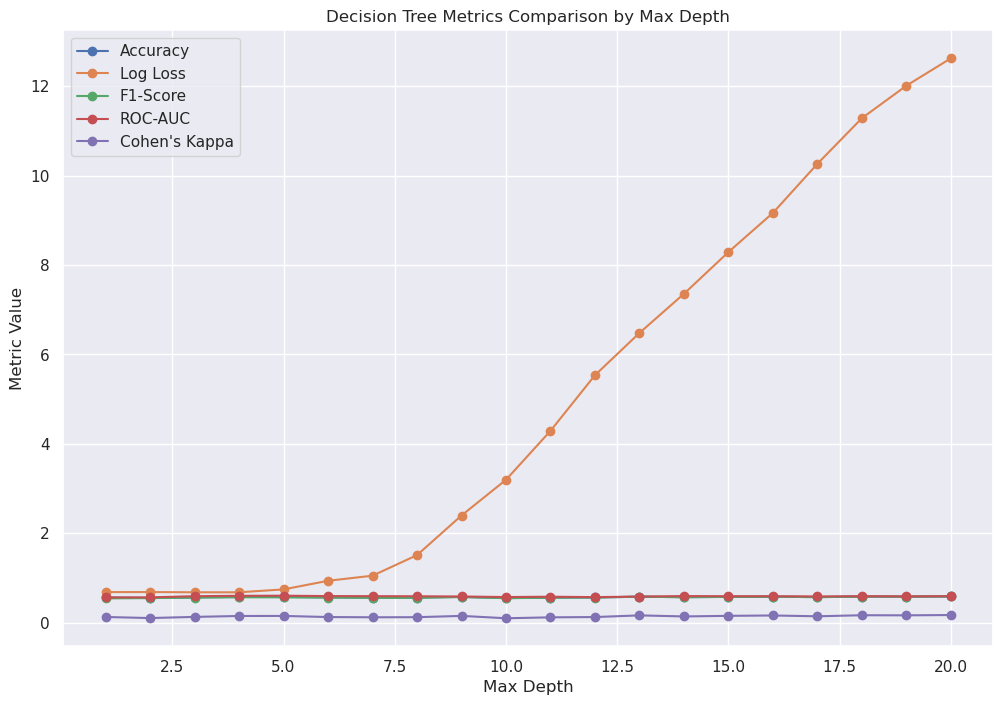

Decision Tree Metrics Comparison by Max Depth:
    Max Depth  Accuracy   Log Loss  F1-Score   ROC-AUC  Cohen's Kappa
0           1  0.563309   0.683391  0.542901  0.563428       0.126826
1           2  0.551491   0.684430  0.549385  0.565915       0.102914
2           3  0.564434   0.679393  0.561030  0.591518       0.128783
3           4  0.574564   0.679066  0.567601  0.600261       0.149249
4           5  0.575127   0.743878  0.565649  0.603131       0.150394
5           6  0.562746   0.936330  0.562600  0.594030       0.125510
6           7  0.559932   1.050688  0.553730  0.592587       0.119982
7           8  0.561058   1.510155  0.554991  0.589763       0.122231
8           9  0.575689   2.396905  0.574160  0.585099       0.151321
9          10  0.549240   3.195821  0.547295  0.572788       0.098547
10         11  0.559370   4.290834  0.558418  0.580123       0.118785
11         12  0.562746   5.535771  0.562541  0.571237       0.125514
12         13  0.581317   6.480765  0.58051

In [58]:
# optimising max-depth of decision trees
# Split the balanced dataset into train and test sets
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Range of max_depth values to test
max_depth_values = range(1, 21)  # Test max_depth from 1 to 20

# Initialize results storage
results = []

# Evaluate Decision Tree Classifier for each max_depth
for max_depth in max_depth_values:
    # Train Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Append metrics to results
    results.append((
        max_depth,
        accuracy,
        logloss,
        f1,
        roc_auc,
        kappa
    ))

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['Max Depth', 'Accuracy', 'Log Loss', 'F1-Score', 'ROC-AUC', "Cohen's Kappa"])

# Identify the best max_depth based on Accuracy
best_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_max_depth = best_row['Max Depth']

# Plot the metrics for each max_depth
plt.figure(figsize=(12, 8))
plt.plot(results_df['Max Depth'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['Max Depth'], results_df['Log Loss'], label='Log Loss', marker='o')
plt.plot(results_df['Max Depth'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.plot(results_df['Max Depth'], results_df['ROC-AUC'], label='ROC-AUC', marker='o')
plt.plot(results_df['Max Depth'], results_df["Cohen's Kappa"], label="Cohen's Kappa", marker='o')

plt.title('Decision Tree Metrics Comparison by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Display the metrics table (optional)
print("Decision Tree Metrics Comparison by Max Depth:")
print(results_df)

print(f"\nBest Max Depth based on Accuracy: {best_max_depth}")

Choose 4

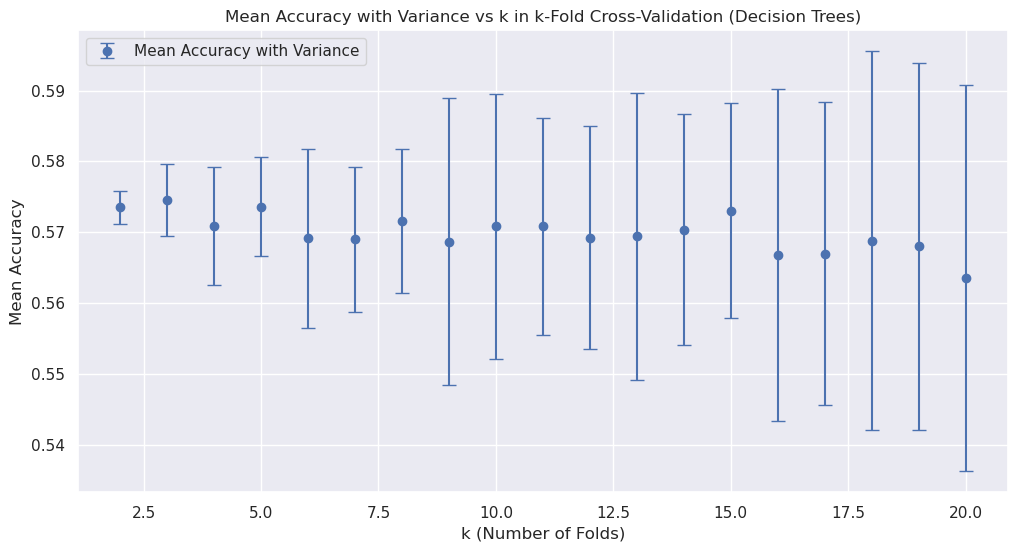

Results for k-Fold Cross-Validation:
     k  Mean Accuracy  Variance
0    2       0.573503  0.000006
1    3       0.574515  0.000025
2    4       0.570914  0.000070
3    5       0.573614  0.000049
4    6       0.569113  0.000160
5    7       0.569000  0.000105
6    8       0.571591  0.000104
7    9       0.568663  0.000412
8   10       0.570799  0.000351
9   11       0.570802  0.000235
10  12       0.569228  0.000248
11  13       0.569455  0.000410
12  14       0.570349  0.000265
13  15       0.573050  0.000231
14  16       0.566752  0.000547
15  17       0.566976  0.000456
16  18       0.568774  0.000717
17  19       0.567988  0.000669
18  20       0.563481  0.000742

Best k: 2.0
Best Mean Accuracy: 0.5735
Best Variance: 0.0000

Final Decision Tree Classifier Metrics:
Accuracy: 0.5629
Variance: 0.0000
Mean Squared Error: 0.4371


In [59]:
# Assuming the balanced dataset is already created as `balanced_df`
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Range of k values for k-fold cross-validation
k_values = range(2, 21)  # Test k from 2 to 10
results = []

# Perform k-fold validation for each k
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train Decision Tree Classifier
        model = DecisionTreeClassifier(max_depth=4, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record mean accuracy and variance for this k
    mean_accuracy = np.mean(accuracies)
    variance = np.var(accuracies)
    results.append((k, mean_accuracy, variance))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['k', 'Mean Accuracy', 'Variance'])

# Select the best k based on the lowest variance and highest accuracy
best_k_row = results_df.loc[results_df['Variance'].idxmin()]
best_k = best_k_row['k']
best_mean_accuracy = best_k_row['Mean Accuracy']
best_variance = best_k_row['Variance']

# Plot mean accuracy with variance as error bars
plt.figure(figsize=(12, 6))

plt.errorbar(
    results_df['k'], 
    results_df['Mean Accuracy'], 
    yerr=np.sqrt(results_df['Variance']),  # Standard deviation as error bars
    fmt='o', 
    label='Mean Accuracy with Variance',
    capsize=5
)

plt.title('Mean Accuracy with Variance vs k in k-Fold Cross-Validation (Decision Trees)')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train a final Decision Tree model with the best k
kf = KFold(n_splits=int(best_k), shuffle=True, random_state=42)
final_accuracies = []
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    final_accuracies.append(accuracy_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Calculate final metrics
final_mean_accuracy = np.mean(final_accuracies)
final_variance = np.var(final_accuracies)
final_mse = np.mean(mse_scores)

# Display results
print("Results for k-Fold Cross-Validation:")
print(results_df)

print(f"\nBest k: {best_k}")
print(f"Best Mean Accuracy: {best_mean_accuracy:.4f}")
print(f"Best Variance: {best_variance:.4f}")

print("\nFinal Decision Tree Classifier Metrics:")
print(f"Accuracy: {final_mean_accuracy:.4f}")
print(f"Variance: {final_variance:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

Choose k=5

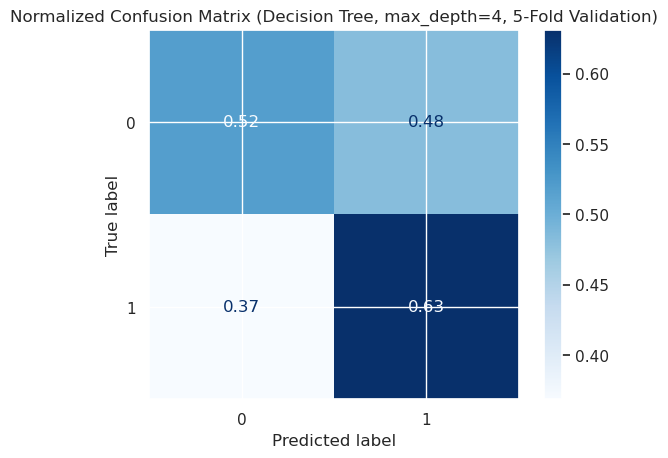

Metrics for Decision Tree Classifier (max_depth=4, 5-Fold Validation):
Accuracy: 0.5736
Log Loss: 0.6873
F1-Score: 0.5689
ROC-AUC: 0.6004
Cohen's Kappa: 0.1493
Mean Squared Error: 0.4264


In [60]:
# Final classification with max_depth=4 and 5-fold validation set
# Assuming balanced_df is the dataset
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
accuracy_list = []
log_loss_list = []
f1_score_list = []
roc_auc_list = []
kappa_list = []
mse_list = []

# Initialize arrays to accumulate confusion matrix data
conf_matrix_sum = np.zeros((2, 2))  # Assuming binary classification

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a Decision Tree Classifier with max_depth=4
    model = DecisionTreeClassifier(max_depth=4, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Accumulate metrics
    accuracy_list.append(accuracy)
    log_loss_list.append(logloss)
    f1_score_list.append(f1)
    roc_auc_list.append(roc_auc)
    kappa_list.append(kappa)
    mse_list.append(mse)
    
    # Accumulate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    conf_matrix_sum += conf_matrix

# Average metrics across folds
final_accuracy = np.mean(accuracy_list)
final_log_loss = np.mean(log_loss_list)
final_f1_score = np.mean(f1_score_list)
final_roc_auc = np.mean(roc_auc_list)
final_kappa = np.mean(kappa_list)
final_mse = np.mean(mse_list)

# Normalize confusion matrix sum for display
final_conf_matrix = conf_matrix_sum / kf.n_splits

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Decision Tree, max_depth=4, 5-Fold Validation)')
plt.show()

# Print metrics
print("Metrics for Decision Tree Classifier (max_depth=4, 5-Fold Validation):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Log Loss: {final_log_loss:.4f}")
print(f"F1-Score: {final_f1_score:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"Cohen's Kappa: {final_kappa:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

In [30]:
#column_names = X_train.columns
#with open("tree.dot", 'w') as f:
#    f = export_graphviz(dt, out_file=f,
#                        feature_names=column_names,  
#                        class_names=['0', '1'],  
#                        filled=True, rounded=True,  
#                        special_characters=False)

In [31]:
# Your Code goes here:
#for i, column in enumerate(column_names):
#    if dt.feature_importances_[i] > 0:
#        print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

In [32]:
#def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
#    """Plots a confusion matrix."""
#    if classes is not None:
#        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
#    else:
#        sns.heatmap(cm, vmin=0., vmax=1.)
#    plt.title(title)
#    plt.ylabel('True label')
#    plt.xlabel('Predicted label')

In [33]:
# Normalised Data

# Your Code goes here:
#cm = confusion_matrix(y_train, prediction_train)
#cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
#plt.figure()
#plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [34]:
# Validation Data

# Your Code goes here:
#cm_2 = confusion_matrix(y_test, prediction_test)
#cm_norm_2 = cm_2/cm_2.sum(axis=1)[:, np.newaxis]
#plt.figure()
#plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Test confusion')

RANDOM FOREST (TRY n_estimaros=500 :number of trees)

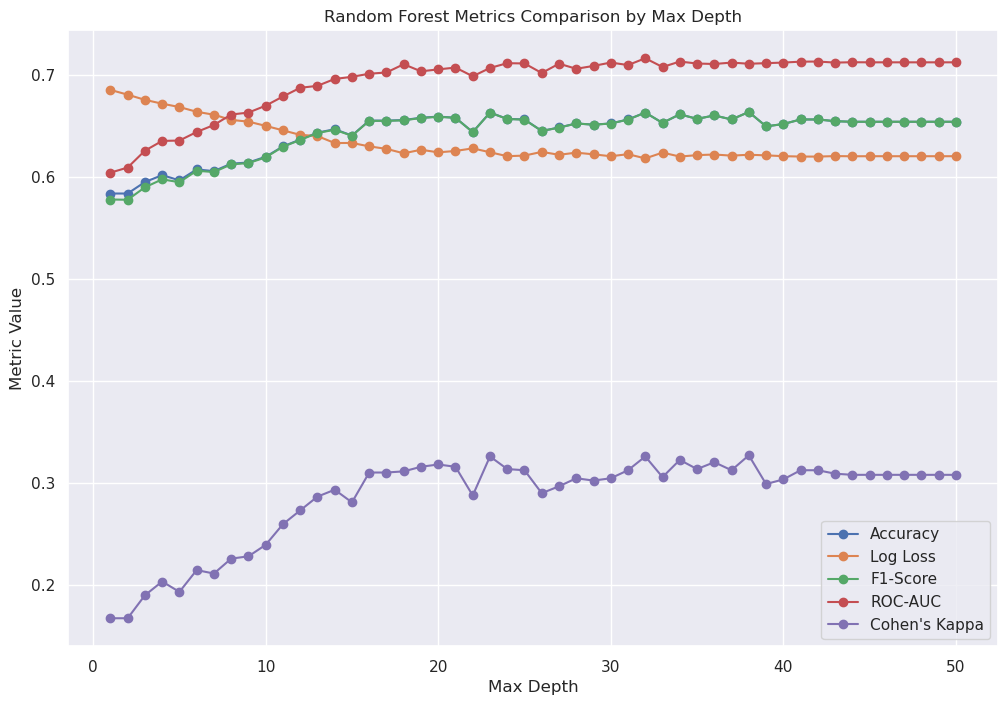

Random Forest Metrics Comparison by Max Depth:
    Max Depth  Accuracy  Log Loss  F1-Score   ROC-AUC  Cohen's Kappa
0           1  0.583568  0.685128  0.577699  0.604030       0.167246
1           2  0.583568  0.680465  0.577469  0.609016       0.167248
2           3  0.594823  0.675396  0.589651  0.625557       0.189748
3           4  0.601576  0.671613  0.597469  0.635144       0.203242
4           5  0.596511  0.668337  0.594647  0.635485       0.193084
5           6  0.607203  0.663696  0.605866  0.643859       0.214458
6           7  0.605515  0.660797  0.604621  0.650736       0.211072
7           8  0.612831  0.655716  0.612130  0.660998       0.225698
8           9  0.613956  0.654025  0.613398  0.662904       0.227945
9          10  0.619584  0.649884  0.618967  0.669661       0.239202
10         11  0.629713  0.645484  0.629448  0.678685       0.259448
11         12  0.636466  0.641060  0.636030  0.687207       0.272960
12         13  0.643219  0.639883  0.642919  0.689097   

In [62]:
# Analysing the effect of and choosing the best max_depth for random forest
# Split the balanced dataset into train and test sets
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Range of max_depth values to test
max_depth_values = range(1, 51)  # Test max_depth from 1 to 20

# Initialize results storage
results = []

# Evaluate Random Forest Classifier for each max_depth
for max_depth in max_depth_values:
    # Train Random Forest Classifier
    model = RandomForestClassifier(max_depth=max_depth, random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Append metrics to results
    results.append((
        max_depth,
        accuracy,
        logloss,
        f1,
        roc_auc,
        kappa
    ))

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['Max Depth', 'Accuracy', 'Log Loss', 'F1-Score', 'ROC-AUC', "Cohen's Kappa"])

# Identify the best max_depth based on Accuracy
best_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_max_depth = best_row['Max Depth']

# Plot the metrics for each max_depth
plt.figure(figsize=(12, 8))
plt.plot(results_df['Max Depth'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['Max Depth'], results_df['Log Loss'], label='Log Loss', marker='o')
plt.plot(results_df['Max Depth'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.plot(results_df['Max Depth'], results_df['ROC-AUC'], label='ROC-AUC', marker='o')
plt.plot(results_df['Max Depth'], results_df["Cohen's Kappa"], label="Cohen's Kappa", marker='o')

plt.title('Random Forest Metrics Comparison by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Display the metrics table (optional)
print("Random Forest Metrics Comparison by Max Depth:")
print(results_df)

print(f"\nBest Max Depth based on Accuracy: {best_max_depth}")

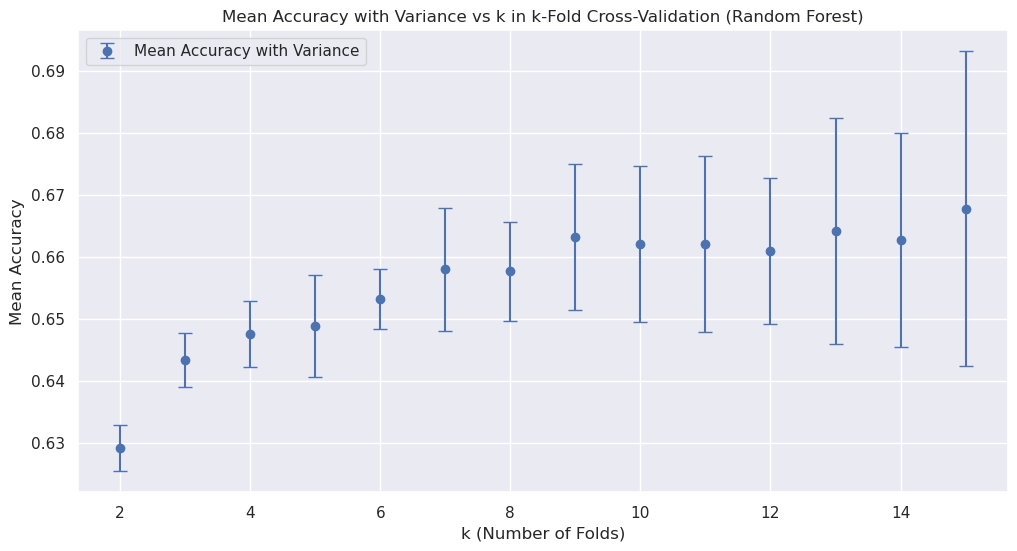

Results for k-Fold Cross-Validation:
     k  Mean Accuracy  Variance
0    2       0.629109  0.000014
1    3       0.643291  0.000019
2    4       0.647569  0.000029
3    5       0.648806  0.000068
4    6       0.653196  0.000023
5    7       0.658036  0.000099
6    8       0.657698  0.000064
7    9       0.663213  0.000140
8   10       0.662092  0.000157
9   11       0.662088  0.000204
10  12       0.660962  0.000140
11  13       0.664227  0.000334
12  14       0.662763  0.000299
13  15       0.667833  0.000645

Best k: 2.0
Best Mean Accuracy: 0.6291
Best Variance: 0.0000

Final Random Forest Classifier Metrics:
Accuracy: 0.6311
Variance: 0.0000
Mean Squared Error: 0.3689


In [64]:
# Assuming the balanced dataset is already created as `balanced_df`
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Range of k values for k-fold cross-validation
k_values = range(2, 16)  # Test k from 2 to 10
results = []

# Perform k-fold validation for each k
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train Random Forest Classifier
        model = RandomForestClassifier(max_depth=23, n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Record mean accuracy and variance for this k
    mean_accuracy = np.mean(accuracies)
    variance = np.var(accuracies)
    results.append((k, mean_accuracy, variance))

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['k', 'Mean Accuracy', 'Variance'])

# Select the best k based on the lowest variance and highest accuracy
best_k_row = results_df.loc[results_df['Variance'].idxmin()]
best_k = best_k_row['k']
best_mean_accuracy = best_k_row['Mean Accuracy']
best_variance = best_k_row['Variance']

# Plot mean accuracy with variance as error bars
plt.figure(figsize=(12, 6))

plt.errorbar(
    results_df['k'], 
    results_df['Mean Accuracy'], 
    yerr=np.sqrt(results_df['Variance']),  # Standard deviation as error bars
    fmt='o', 
    label='Mean Accuracy with Variance',
    capsize=5
)

plt.title('Mean Accuracy with Variance vs k in k-Fold Cross-Validation (Random Forest)')
plt.xlabel('k (Number of Folds)')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Train a final Random Forest model with the best k
kf = KFold(n_splits=int(best_k), shuffle=True, random_state=42)
final_accuracies = []
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    final_accuracies.append(accuracy_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

# Calculate final metrics
final_mean_accuracy = np.mean(final_accuracies)
final_variance = np.var(final_accuracies)
final_mse = np.mean(mse_scores)

# Display results
print("Results for k-Fold Cross-Validation:")
print(results_df)

print(f"\nBest k: {best_k}")
print(f"Best Mean Accuracy: {best_mean_accuracy:.4f}")
print(f"Best Variance: {best_variance:.4f}")

print("\nFinal Random Forest Classifier Metrics:")
print(f"Accuracy: {final_mean_accuracy:.4f}")
print(f"Variance: {final_variance:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

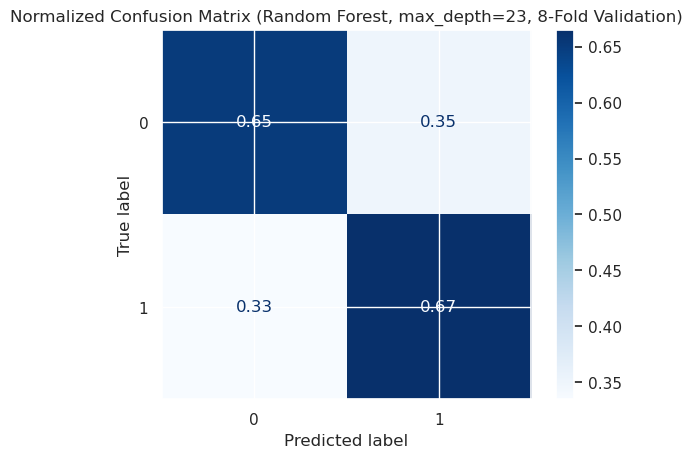

Metrics for Random Forest Classifier (max_depth=23, 8-Fold Validation):
Accuracy: 0.6577
Log Loss: 0.6180
F1-Score: 0.6577
ROC-AUC: 0.7162
Cohen's Kappa: 0.3155
Mean Squared Error: 0.3423


In [65]:
# Final classification with max_depth=23, n_estimators=100, 8-fold validation
# Assuming balanced_df is the dataset
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

# Initialize 8-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)

# Initialize metrics
accuracy_list = []
log_loss_list = []
f1_score_list = []
roc_auc_list = []
kappa_list = []
mse_list = []

# Initialize arrays to accumulate confusion matrix data
conf_matrix_sum = np.zeros((2, 2))  # Assuming binary classification

# Perform 8-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train a Random Forest Classifier with max_depth=23
    model = RandomForestClassifier(max_depth=23, random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    kappa = cohen_kappa_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Log Loss
    try:
        logloss = log_loss(y_test, y_pred_proba)
    except ValueError:
        logloss = np.nan  # Handle cases where log loss might fail
    
    # Accumulate metrics
    accuracy_list.append(accuracy)
    log_loss_list.append(logloss)
    f1_score_list.append(f1)
    roc_auc_list.append(roc_auc)
    kappa_list.append(kappa)
    mse_list.append(mse)
    
    # Accumulate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    conf_matrix_sum += conf_matrix

# Average metrics across folds
final_accuracy = np.mean(accuracy_list)
final_log_loss = np.mean(log_loss_list)
final_f1_score = np.mean(f1_score_list)
final_roc_auc = np.mean(roc_auc_list)
final_kappa = np.mean(kappa_list)
final_mse = np.mean(mse_list)

# Normalize confusion matrix sum for display
final_conf_matrix = conf_matrix_sum / kf.n_splits

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Random Forest, max_depth=23, 8-Fold Validation)')
plt.show()

# Print metrics
print("Metrics for Random Forest Classifier (max_depth=23, 8-Fold Validation):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Log Loss: {final_log_loss:.4f}")
print(f"F1-Score: {final_f1_score:.4f}")
print(f"ROC-AUC: {final_roc_auc:.4f}")
print(f"Cohen's Kappa: {final_kappa:.4f}")
print(f"Mean Squared Error: {final_mse:.4f}")

In [36]:
# Your Code goes here:
#rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
#rf.fit(X_train, y_train)
#prediction_test = rf.predict(X=X_test)
#print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
#cm = confusion_matrix(y_test, prediction_test)
#cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
#plt.figure()
#plot_confusion_matrix(cm_norm, classes=rf.classes_)


In [37]:
# How high can you get the performance of the classifier by changing the max depth of the trees (max_depth), or the max_features parameters? Try a few values just to get a look. Don't do a grid search or anything in-depth, just get a feel. Try the same settings twice...do you get the same accuracy?
#from itertools import product
#n_estimators = 500
#max_features = [1, 'sqrt', 'log2']
#max_depths = [None, 2, 5, 10]
#for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
#    rf = RandomForestClassifier(n_estimators=n_estimators, 
#                                criterion='entropy', 
#                                max_features=f, 
#                                max_depth=d, 
#                                n_jobs=2,
#                                random_state=1337)
#   rf.fit(X_train, y_train)
#    prediction_test = rf.predict(X=X_test)
#    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
#    cm = confusion_matrix(y_test, prediction_test)
#    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
#    plt.figure()
#    plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

In [38]:
# Compare the feature importances as estimated with the decision tree and random forest classifiers.
#rf = RandomForestClassifier(n_estimators=500, 
#                            criterion='entropy', 
#                            max_features=1, 
#                            max_depth=10, 
#                            n_jobs=2)
#rf.fit(X_train, y_train)
#_, ax1 = plt.subplots(1, 1, figsize=(16,6))
#xx = np.arange(len(dt.feature_importances_))
#ax1.bar(xx, dt.feature_importances_)
#ax1.set_xticks(xx)
#ax1.set_xticklabels(column_names, rotation='vertical')
#ax1.set_title('Decision tree depth 3 importances')
#plt.show()

#_, ax2 = plt.subplots(1, 1, figsize=(16,6))
#ax2.bar(xx, rf.feature_importances_)
#ax2.set_xticks(xx)
#ax2.set_xticklabels(column_names, rotation='vertical')
#ax2.set_title('Random forest max features=1 , max depth=10')
#plt.show()

#for i, column in enumerate(column_names):
#    if dt.feature_importances_[i] > 0 or rf.feature_importances_[i]:
#        print('Importance of feature {}, DT: {:.3f}, RF: {:.3f}'.format(column, dt.feature_importances_[i], rf.feature_importances_[i]))